In [1]:
#Imports
import sys
sys.path.append('../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

In [2]:
data = dp.getXYdata_wXYerr('data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (list(a) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1 = np.asarray(v_err1)

In [3]:
def f(r,M,n,re,):
     return np.sqrt(nf.bh_v(r_dat,M,load=True)**2 
                    + nf.h_v(r,load=True)**2 
                    + nf.b_v(r,n,re,load=True)**2 
                    + nf.d_v(r,load=True)**2)

In [ ]:
#Setup
weighdata = 1/v_err1
l_mod = lm.Model(f)
params = l_mod.make_params()
#Black Hole
params.add('M', value=nf.Mbh_def, min=0) #Mass
#Bulge
params.add('n', value=nf.n_c, min=0) 
params.add('re', value=nf.re_c, min=0)

#Do fit
l_fit = l_mod.fit(v_dat,params,r=r_dat,weights=weighdata)

../python/NGC5533_functions.py:176: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return si.quad(f, m, np.inf,args=(m,n,re))[0]
../python/NGC5533_functions.py:176: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return si.quad(f, m, np.inf,args=(m,n,re))[0]
../python/NGC5533_functions.py:182: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be us

In [ ]:
#Define Stuff
l_dict = l_fit.best_values
#Black Hole
l_M = l_dict['M']
#Bulge
l_n = l_dict['n']
l_re = l_dict['re']

l_curve = f(r_dat,l_M,l_n,l_re)

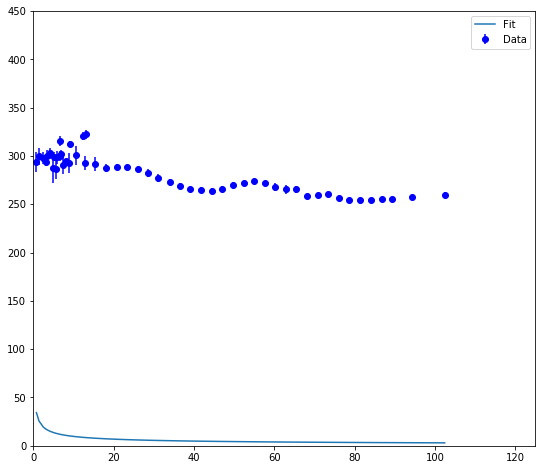

In [10]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,125)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,label='Fit')
plt.plot(r_dat,nf.bh_v(r_dat,l_M,load=True),label='Black Hole Only')
plt.plot(r_dat,nf.b_v(r_dat,l_n,l_re,load=True),label='Bulge Only')
plt.plot(r_dat,nf.bh_v(r_dat,load=True),label='Black Hole (Defaults)')
plt.plot(r_dat,nf.b_v(r_dat,load=True),label='Bulge (Defaults)')


plt.legend()
plt.savefig('Fitting_with_library.png')
plt.show()

l_fit

In [ ]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,label='Fit')
plt.plot(r_dat,nf.bh_v(r_dat,l_M,load=True),label='Black Hole Only')
plt.plot(r_dat,nf.b_v(r_dat,l_n,l_re,load=True),label='Bulge Only')
plt.plot(r_dat,nf.bh_v(r_dat,load=True),label='Black Hole (Defaults)')
plt.plot(r_dat,nf.b_v(r_dat,load=True),label='Bulge (Defaults)')


plt.legend()
plt.savefig('Fitting_with_library.png')
plt.show()